# Import

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.cluster import DBSCAN

from pathlib import Path

In [39]:
def show_img(img, cmap=None):
    fig, ax  = plt.subplots(figsize=(16, 9))

    ax.imshow(img, cmap=cmap)
    ax.axis("off")

    plt.show()

# Input

На вход модуля подается извлеченная область графика, а также x координаты в пикселях двух различных значений глубин, и двух различных значений измерений (есди предполагать что шкала линейная), то можно получить значение для каждого пикселя в нотации (глубина, измерение). 

## Пример

есть изображение, для которого уже получили баундинг бокс графика, а также координаты min, max DEPTH (7000, 8450) и каротажа (1.6, 2.6):

(190, 43)
(305, 1047)


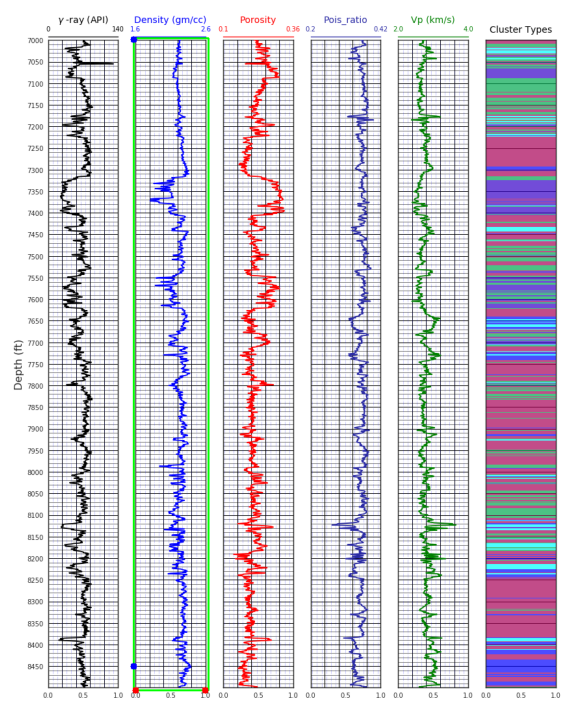

In [40]:
IMG = str(Path("..\data\image_2024-05-24_13-04-18.png"))

orig_img = cv2.imread(IMG)
img = orig_img.copy()

# top, left, height, width
coco_bbox = [190,43,115.46,1004.34]
x,y,w,h = map(int, coco_bbox)

start_point = (x, y)
end_point = (x + w, y + h)

print(start_point)
print(end_point)
cv2.rectangle(img, start_point, end_point, (0,255,0), 2)
# Show min depth (45th y-pixel)
cv2.circle(img, (190, 45), radius=5, color=(0, 0, 255), thickness=-1)
# Show max depth (1010th y-pixel)
cv2.circle(img, (190, 1010), radius=5, color=(0, 0, 255), thickness=-1)

# Show min density (193th x-pixel)
cv2.circle(img, (193, 1047), radius=5, color=(255, 0, 0), thickness=-1)
# Show max density (300th x-pixel)
cv2.circle(img, (300, 1047), radius=5, color=(255, 0, 0), thickness=-1)

show_img(img)

## Пайплайн

### Шаг 1. Вырежем область с графиком

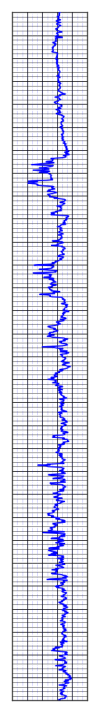

(1004, 115, 3)
190 43 305 1047


In [41]:
opencv_bbox = start_point + end_point
x_min, y_min, x_max, y_max = opencv_bbox

img_cropped = orig_img[y_min:y_max, x_min:x_max]
show_img(img_cropped)
print(img_cropped.shape)
print(x_min, y_min, x_max, y_max)

### Шаг 2. Получаем попиксельную сетку по оси глубины и измерения

In [42]:
# Input
y_min_val = 7000
y_max_val = 8450
axis_y_min = 45
axis_y_max = 1010

x_min_val = 1.6
x_max_val = 2.6
axis_x_min = 193
axis_x_max = 300

получаем нормализованные координаты

In [43]:
y_min_ix = axis_y_min - y_min
y_max_ix = (axis_y_max - y_max) + img_cropped.shape[0]
x_min_ix = axis_x_min - x_min
x_max_ix = (axis_x_max - x_max) + img_cropped.shape[1]

print(y_min_ix)
print(y_max_ix)
print(x_min_ix)
print(x_max_ix)

2
967
3
110


In [44]:
dVal_y = (y_max_val - y_min_val) / (y_max_ix - y_min_ix)
dVal_x = (x_max_val - x_min_val) / (x_max_ix - x_min_ix)

y_min_val = y_min_val + (0 - y_min_ix) * dVal_y
y_max_val = y_max_val + (img_cropped.shape[0] - y_max_ix) * dVal_y
y_axis = np.linspace(y_min_val, y_max_val, num=img_cropped.shape[0], endpoint=True)

x_min_val = x_min_val + (0 - x_min_ix) * dVal_x
x_max_val = x_max_val + (img_cropped.shape[1] - x_max_ix) * dVal_x
x_axis = np.linspace(x_min_val, x_max_val, num=img_cropped.shape[1], endpoint=True)

In [45]:
dVal_x

0.009345794392523364

проверим что точек в оси столько же, что и пикселей

In [46]:
print(img_cropped.shape)
print(x_axis)
print(x_axis.shape)
print(y_axis)
print(y_axis.shape)

(1004, 115, 3)
[1.57196262 1.58139039 1.59081817 1.60024594 1.60967372 1.61910149
 1.62852927 1.63795704 1.64738482 1.65681259 1.66624037 1.67566814
 1.68509592 1.69452369 1.70395147 1.71337924 1.72280702 1.73223479
 1.74166257 1.75109034 1.76051812 1.76994589 1.77937367 1.78880144
 1.79822922 1.80765699 1.81708477 1.82651254 1.83594032 1.84536809
 1.85479587 1.86422364 1.87365142 1.88307919 1.89250697 1.90193474
 1.91136252 1.92079029 1.93021807 1.93964584 1.94907362 1.95850139
 1.96792917 1.97735694 1.98678472 1.99621249 2.00564027 2.01506804
 2.02449582 2.03392359 2.04335137 2.05277914 2.06220692 2.07163469
 2.08106247 2.09049024 2.09991802 2.10934579 2.11877357 2.12820134
 2.13762912 2.14705689 2.15648467 2.16591244 2.17534022 2.18476799
 2.19419577 2.20362354 2.21305132 2.22247909 2.23190687 2.24133465
 2.25076242 2.2601902  2.26961797 2.27904575 2.28847352 2.2979013
 2.30732907 2.31675685 2.32618462 2.3356124  2.34504017 2.35446795
 2.36389572 2.3733235  2.38275127 2.39217905 2.4

### Шаг 3. Выявляем график на картинке

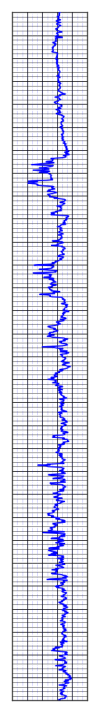

In [47]:
show_img(img_cropped)

In [48]:
kernel = np.ones((4, 4), np.uint8) 

filtered = cv2.dilate(img_cropped, kernel, iterations=1)
filtered = cv2.erode(filtered, kernel, iterations=1)

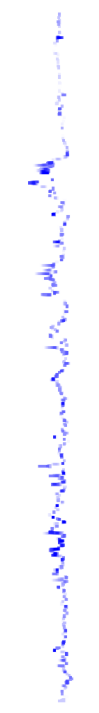

In [49]:
show_img(filtered)

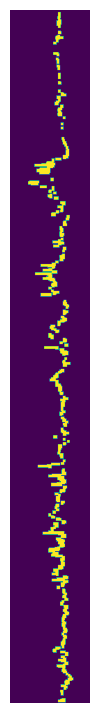

In [50]:
t = 250
grayscaled_filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2GRAY)
grayscaled_filtered[grayscaled_filtered < t] = 0
grayscaled_filtered[grayscaled_filtered >= t] = 255
grayscaled_filtered = cv2.bitwise_not(grayscaled_filtered)
show_img(grayscaled_filtered)

### Шаг 4. Ищем пиксели относящиеся к графику, как аномалии в DBSCAN

In [51]:
filtered.shape

(1004, 115, 3)

In [52]:
filtered[0]

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255

In [53]:
from sklearn.cluster import DBSCAN
labels = []
for i in tqdm(range(filtered.shape[0])):
    clustering = DBSCAN(eps=0.5, min_samples=5).fit(filtered[i])
    labels.append(clustering.labels_)
labels = np.array(labels)

100%|██████████| 1004/1004 [00:00<00:00, 1369.03it/s]


In [54]:
labels[labels != -1] = 0
labels[labels == -1] = 1

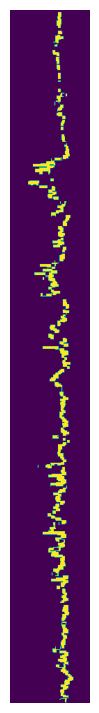

In [55]:
show_img(labels)

In [57]:
labels.shape

(1004, 115)

In [68]:
np.argwhere(labels[151] == 1).flatten()

array([67, 68, 69, 70, 71, 72, 73, 74], dtype=int64)

In [69]:
x_values = []
y_values = []
for i in range(labels.shape[0]):
    ixs = np.argwhere(labels[i] == 1).flatten()
    if len(ixs) > 0:
        x_values.append(x_axis[np.random.choice(ixs, 3)[0]])
        y_values.append(y_axis[i])

x_values = np.array(x_values)
y_values = np.array(y_values)

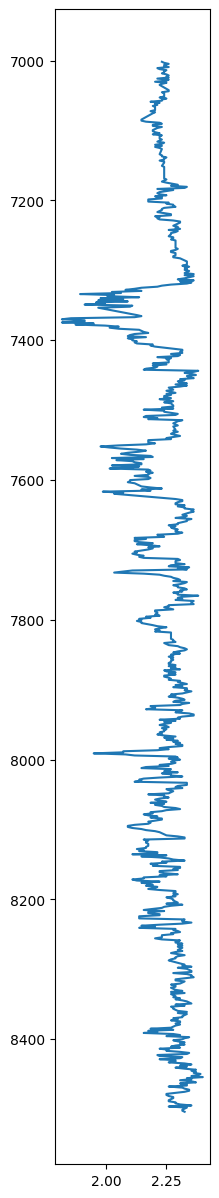

In [77]:
fig, axs = plt.subplots(1,1, figsize=(2, 15))
axs.invert_yaxis()
axs.plot(x_values, y_values)